Follow along with [ResNet50RetinaNet - COCO 2017.ipynb](https://github.com/fizyr/keras-retinanet/blob/master/examples/ResNet50RetinaNet%20-%20COCO%202017.ipynb)

Testing out RetinaNet

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.preprocessing.coco import CocoGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

Using TensorFlow backend.


In [2]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

## Load RetinaNet model

[download link](https://delftrobotics-my.sharepoint.com/personal/h_gaiser_fizyr_com/_layouts/15/guestaccess.aspx?docid=0386bb358d0d44762a7c705cdac052c2f&authkey=AfdlNvj1hPD8ZPShcqUFUZg&expiration=2017-12-28T16%3A09%3A58.000Z&e=5585e7262ac64651bf59990b54b406cd)

In [3]:
from keras_retinanet.models.resnet import custom_objects

In [4]:
model = keras.models.load_model('data/retinanet-model/resnet50_coco_best_v1.2.2.h5', custom_objects=custom_objects)
# print(model.summary())

/Users/WayNoxchi/Miniconda3/envs/tfkeras/lib/python3.6/site-packages/keras/models.py:271: UserWarning: Output "non_maximum_suppression_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_1" during training.
  sample_weight_mode=sample_weight_mode)


In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

## Initialize Data Generators

In [6]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# createa a generator for testing data
val_generator = CocoGenerator('data/COCO', 'val2017', val_image_data_generator, batch_size=1,)
index = 0

loading annotations into memory...
Done (t=0.75s)
creating index...
index created!


Wow it worked. Downloaded 2017 Val images [5K/1GB] and 2017 Train/Val annotations [241MB] (smallest datasets I could find) from [here](http://cocodataset.org/#download). Put them in a 'COCO' folder, and ran the above. Note: `val2017/` has to be inside an `images/` folder.

## Run Detection on Example

processing time:  8.063735008239746


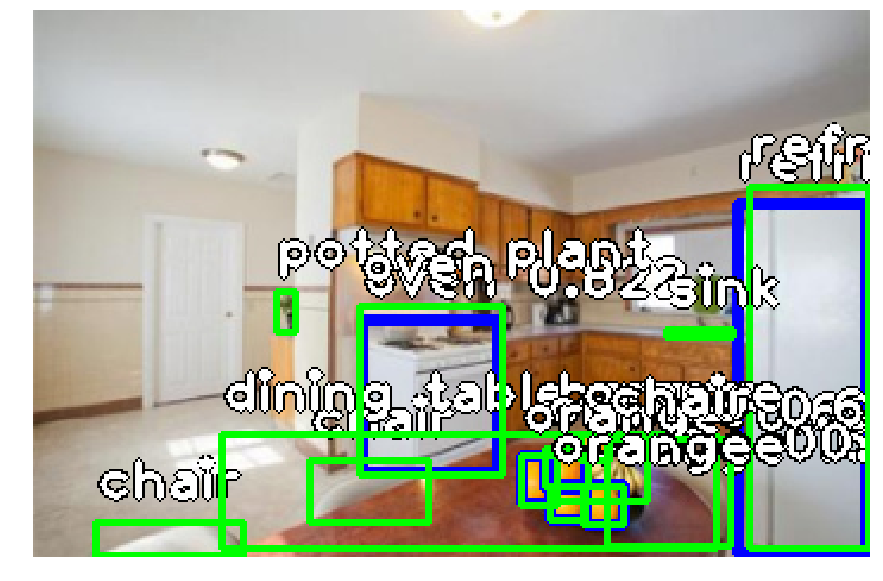

In [9]:
# load image
image = val_generator.load_image(index)

# copy to draw on 
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = val_generator.preprocess_image(image)
image, scale = val_generator.resize_image(image)
annotations = val_generator.load_annotations(index)
index += 1

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,0,255), 3)
    caption = f'{val_generator.label_to_name(label)} {score:.3f}'
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0,0,0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255,255,255), 2)
    
# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(val_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0,0,0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255,255,255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [12]:
type(image), image.shape

(numpy.ndarray, (600, 918, 3))

Hell yeah, the image objects are just NumPy arrays from jpegs. That means it'll be very easy to just run RetinaNet on any old image of mine.

---

## More testing

In [61]:
def detect(image=None, index=0):
    # load image if none given:
    if type(image) == type(None):
        image = val_generator.load_image(index)

    # copy to draw on 
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = val_generator.preprocess_image(image)
    image, scale = val_generator.resize_image(image)
    annotations = val_generator.load_annotations(index)
    index += 1

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.5:
            continue
        b = detections[0, idx, :4].astype(int)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,0,255), 3)
        caption = f'{val_generator.label_to_name(label)} {score:.3f}'
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0,0,0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255,255,255), 2)

    # visualize annotations
    for annotation in annotations:
        label = int(annotation[4])
        b = annotation[:4].astype(int)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
        caption = "{}".format(val_generator.label_to_name(label))
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0,0,0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255,255,255), 2)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

processing time:  8.254160165786743


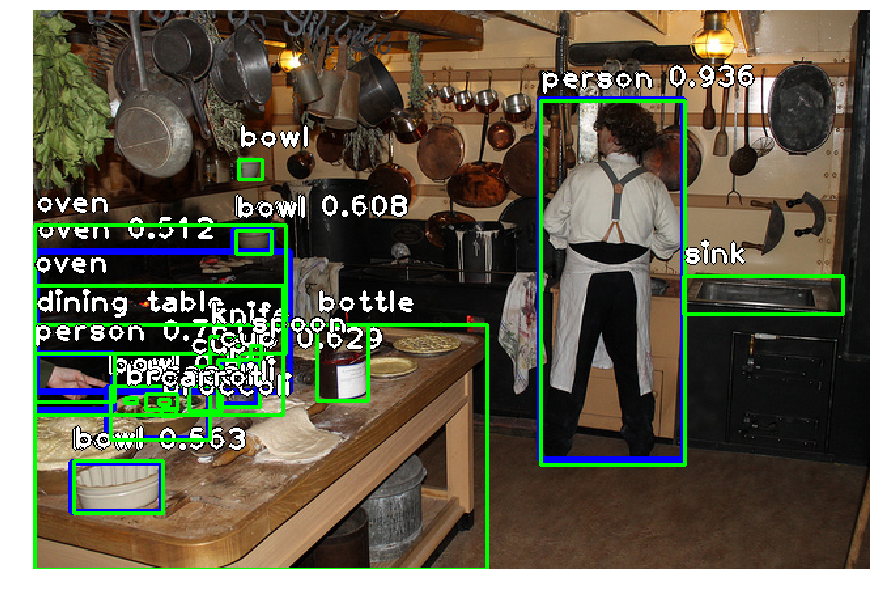

In [19]:
detect()

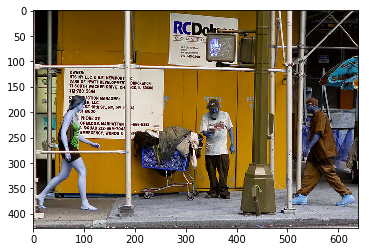

In [23]:
plt.imshow(val_generator.load_image(index))

In [24]:
index

2

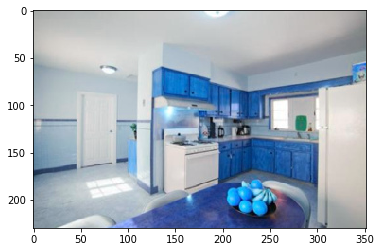

In [30]:
plt.imshow(val_generator.load_image(1))

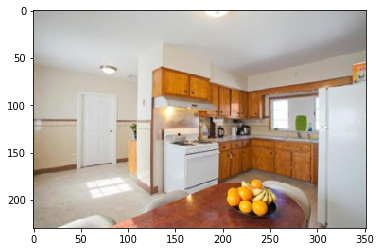

In [38]:
image = val_generator.load_image(1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [40]:
from PIL import Image
image = Image.open('blah.jpg')

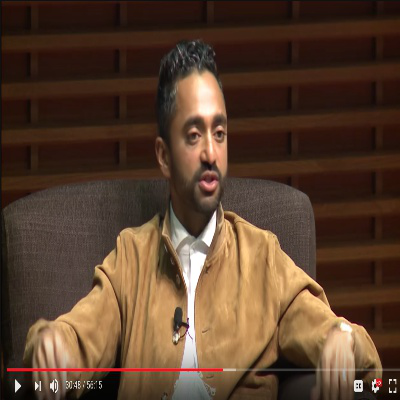

In [41]:
image

processing time:  5.3817079067230225


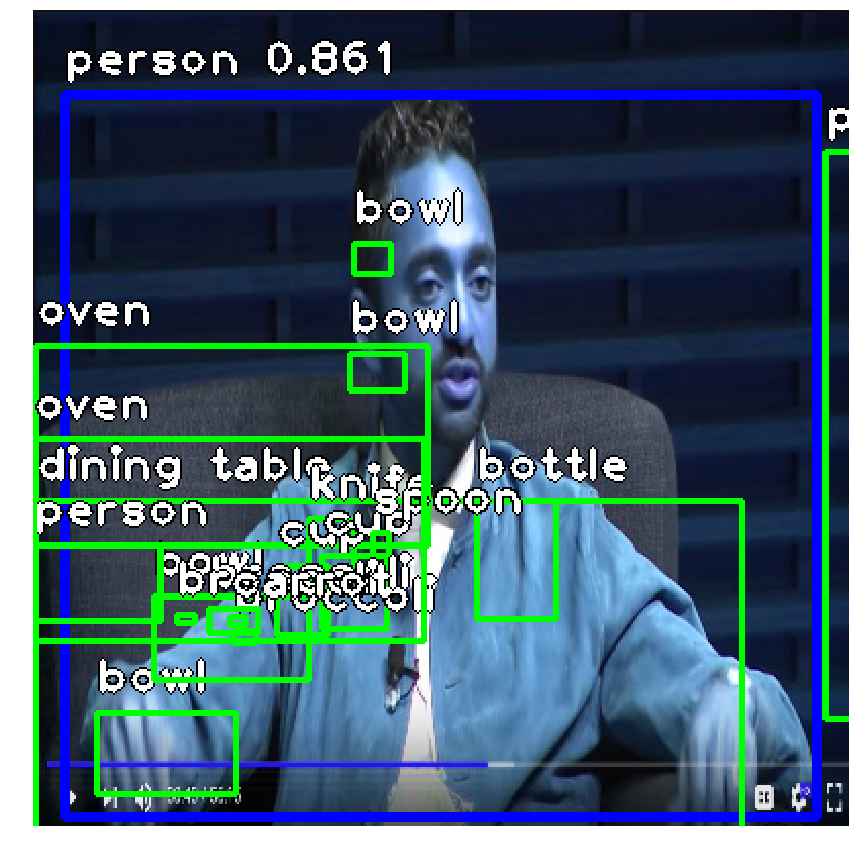

In [51]:
detect(np.asarray(image))

processing time:  5.488654851913452


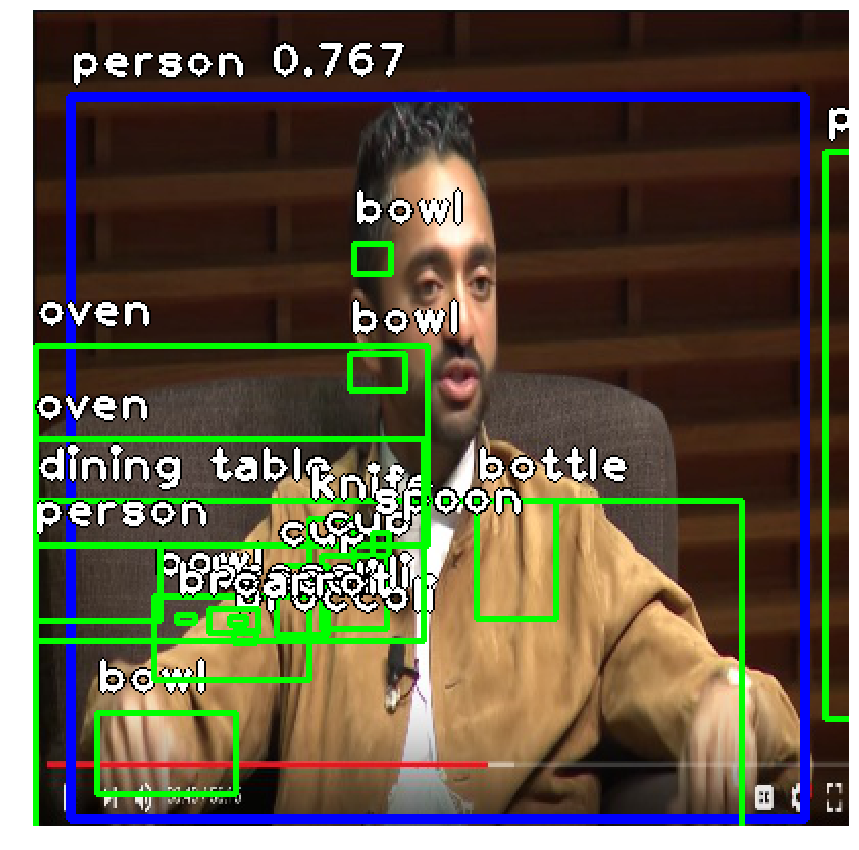

In [62]:
detect(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR))

### Seeing what it looks like if I liimt it to the top 1 or few annotations:

In [71]:
def detect(image=None, index=0, threshold=0.5):
    # load image if none given:
    if type(image) == type(None):
        image = val_generator.load_image(index)

    # copy to draw on 
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = val_generator.preprocess_image(image)
    image, scale = val_generator.resize_image(image)
    annotations = val_generator.load_annotations(index)
    index += 1

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < threshold:
            continue
        b = detections[0, idx, :4].astype(int)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,0,255), 3)
        caption = f'{val_generator.label_to_name(label)} {score:.3f}'
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0,0,0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255,255,255), 2)

    # visualize annotations
    for annotation in annotations:
        label = int(annotation[4])
        b = annotation[:4].astype(int)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
        caption = "{}".format(val_generator.label_to_name(label))
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0,0,0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255,255,255), 2)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

    return annotations

processing time:  7.670812129974365


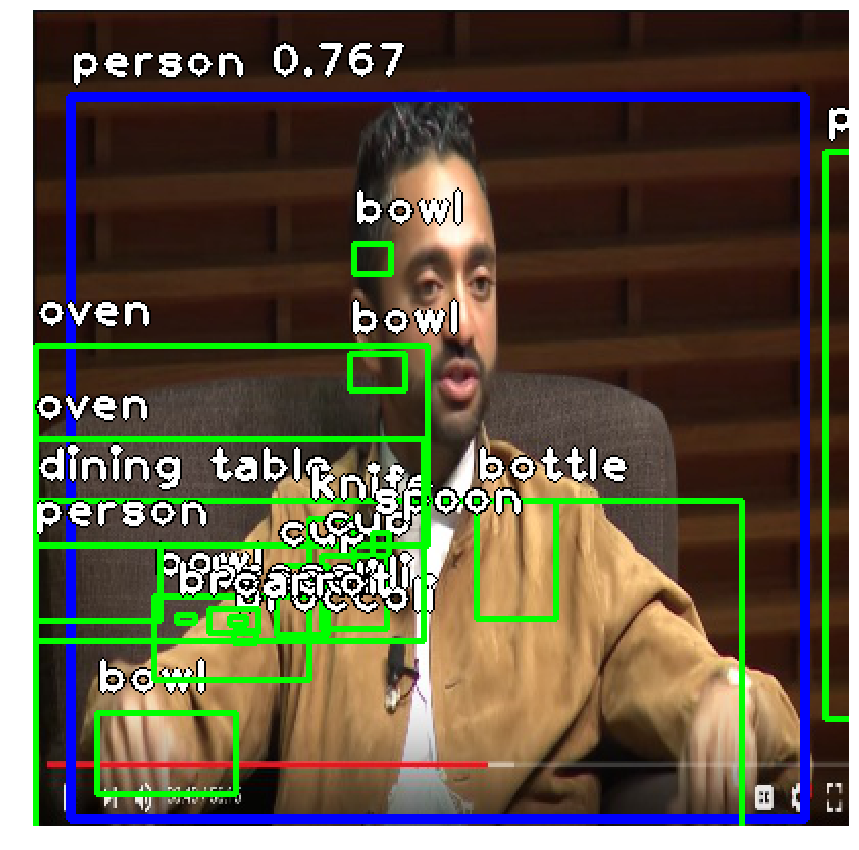

In [72]:
image = Image.open('blah.jpg')
x = detect(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR), threshold=0.7)

In [73]:
x

array([[ 217.62,  240.54,  256.61,  298.29,   39.  ],
       [   1.  ,  240.24,  347.63,  427.  ,   60.  ],
       [ 388.66,   69.92,  498.07,  347.54,    0.  ],
       [ 135.57,  249.43,  157.89,  278.22,   43.  ],
       [  31.28,  344.  ,   99.4 ,  384.83,   45.  ],
       [  59.63,  287.36,  135.7 ,  328.66,   45.  ],
       [   1.36,  164.33,  193.92,  262.7 ,   69.  ],
       [   0.  ,  262.81,   62.16,  299.58,    0.  ],
       [ 119.4 ,  272.51,  144.22,  306.76,   41.  ],
       [ 141.47,  267.91,  173.66,  303.77,   41.  ],
       [ 155.97,  168.95,  182.  ,  186.08,   45.  ],
       [ 157.2 ,  114.15,  175.06,  129.97,   45.  ],
       [  98.75,  304.78,  109.53,  310.35,   50.  ],
       [ 166.03,  256.36,  174.85,  274.94,   44.  ],
       [  86.41,  293.97,  110.37,  305.15,   50.  ],
       [  70.14,  296.16,   79.42,  300.74,   50.  ],
       [   0.  ,  210.9 ,  191.36,  309.88,   69.  ],
       [  96.69,  297.09,  104.53,  301.95,   51.  ],
       [ 497.25,  203.4 ,  6

In [216]:
def detect_one(image=None, index=0, threshold=0.5):
    # load image if none given:
    if type(image) == type(None):
        image = val_generator.load_image(index)

    # copy to draw on 
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = val_generator.preprocess_image(image)
    image, scale = val_generator.resize_image(image)
#     annotations = val_generator.load_annotations(index)
#     index += 1

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    count = 0
    max_score = -1
    
    from collections import OrderedDict
    
#     dets = []
    
#     max_score2 = -1

    caption = ""
    
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        max_score = max(max_score, score)
        if score < threshold:
            continue
        b = detections[0, idx, :4].astype(int)
        
        assert len(b) == 4
        
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,0,255), 3)
        caption = f'{val_generator.label_to_name(label)} {score:.3f}'
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), 3, cv2.LINE_AA)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)

    print(caption)
    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

processing time:  8.694875955581665


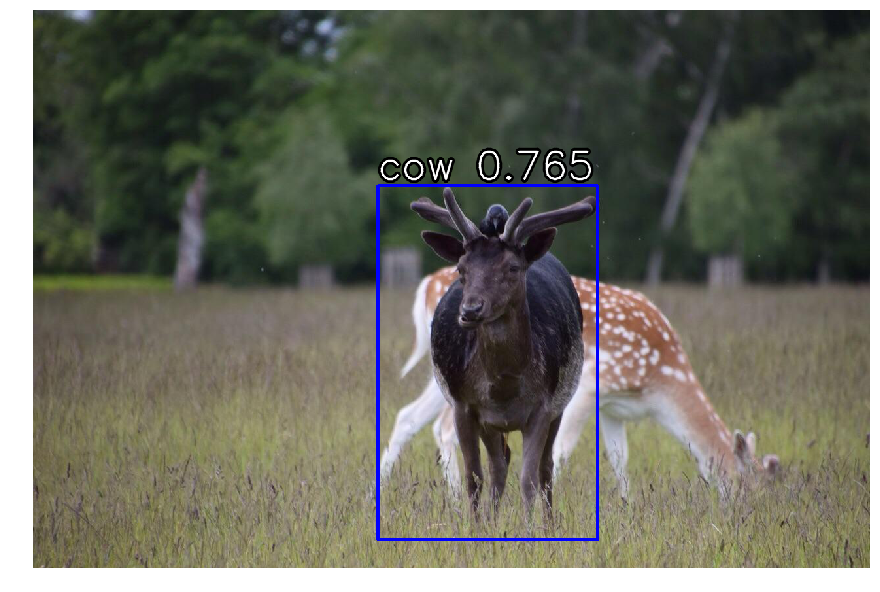

In [130]:
# image = Image.open('blah.jpg')
# image = Image.open('realtalkreza.jpg')
image = Image.open('toolate.jpg')
# image = Image.open('realtalkreza.jpg')
# image = Image.open('ricedude.jpg')
detect_one(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR), threshold=0.7)

In [105]:
"Cxahum".format(3)

'Cxahum'

In [ ]:
??cv2.putText()

Alright. Let's start using this for my dataset.

---

In [133]:
os.listdir('data/')

['labels.csv',
 '.DS_Store',
 'retinanet-model',
 'labels',
 'test_z',
 'COCO',
 'train']

In [143]:
os.listdir('data/train')[:4]

['002439-003316', '006242-006439', '001883-002438', '006673-006860']

In [152]:
trainpath = 'data/train/'
folder = os.listdir('data/train')[0] + '/'

In [153]:
trainpath, folder

('data/train/', '002439-003316/')

In [163]:
os.listdir(trainpath + folder)[:5]

['003301.jpg', '002779.jpg', '003315.jpg', '002745.jpg', '002751.jpg']

In [165]:
folders = os.listdir(trainpath); folders

['002439-003316',
 '006242-006439',
 '001883-002438',
 '006673-006860',
 '004402-004684',
 '001435-001882',
 '005592-006111',
 '003604-003904',
 '001190-001434',
 '007365-007636',
 '003905-004151',
 '006861-007364',
 '005106-005451',
 '005452-005591',
 '000413-000569',
 '006112-006241',
 '003317-003603',
 '004152-004401',
 '000000-000412',
 '004685-005105',
 '006549-006672',
 '000570-001189',
 '006440-006548']

In [172]:
folder = os.listdir('data/train')[0] + '/'

In [173]:
fpaths = [trainpath + folder + fname for fname in os.listdir(trainpath + folder)]

In [175]:
fpaths[:4]

['data/train/002439-003316/003301.jpg',
 'data/train/002439-003316/002779.jpg',
 'data/train/002439-003316/003315.jpg',
 'data/train/002439-003316/002745.jpg']

Image path: data/train/002439-003316/002823.jpg
processing time:  5.561688661575317


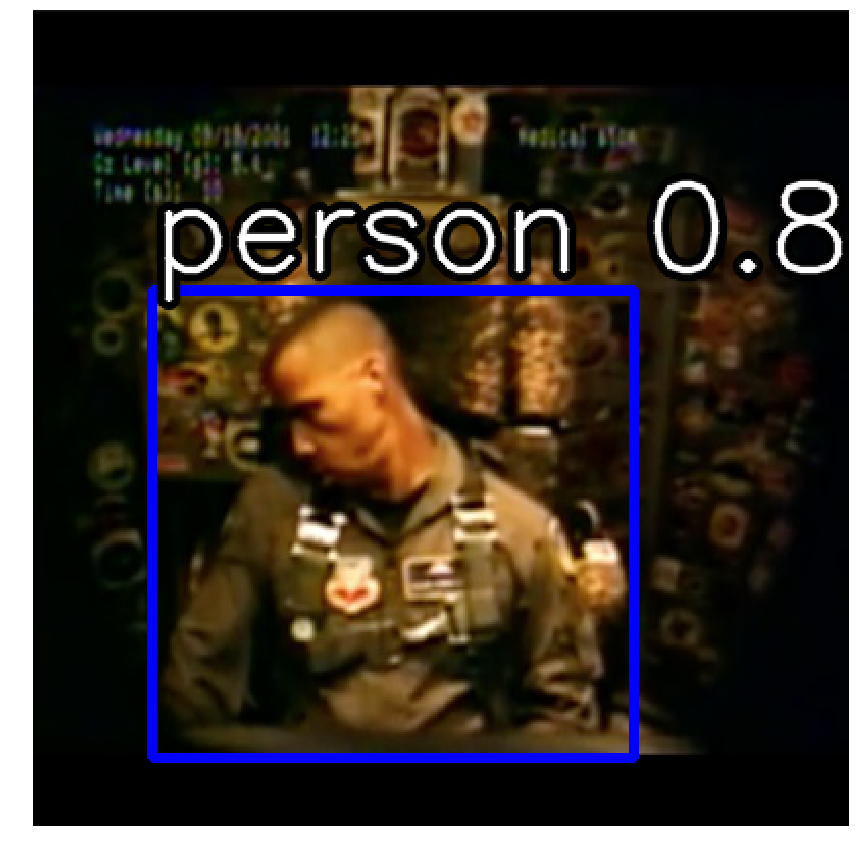

In [177]:
idx = np.random.choice(np.arange(len(fpaths)))
print(f'Image path: {fpaths[idx]}')

image = fpaths[idx]

image = Image.open(image)
image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

detect_one(image, threshold=0.7)

Image path: data/train/002439-003316/002771.jpg
processing time:  6.151478052139282


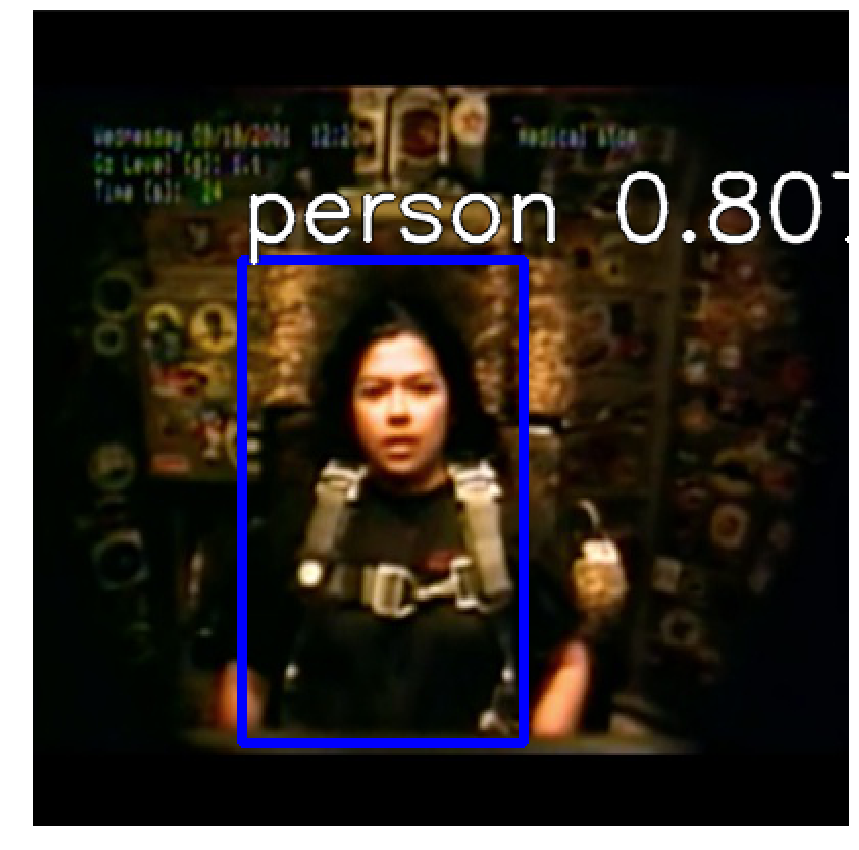

In [185]:
idx = np.random.choice(np.arange(len(fpaths)))
print(f'Image path: {fpaths[idx]}')

image = fpaths[idx]

image = Image.open(image)
image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

detect_one(image, threshold=0.8)

In [199]:
def detect_pilot(trainpath = 'data/train/', folder="", threshold=0.5):
    if folder == "":
        print("No folder specified")
        return
    
    fpaths = [trainpath + folder + '/' + fname for fname in os.listdir(trainpath + folder)]
    
    idx = np.random.choice(np.arange(len(fpaths)))
    print(f'Image path: {fpaths[idx]}')

    image = fpaths[idx]

    image = Image.open(image)
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    detect_one(image, threshold=threshold)

Image path: data/train/004685-005105/004952.jpg
processing time:  5.685894250869751


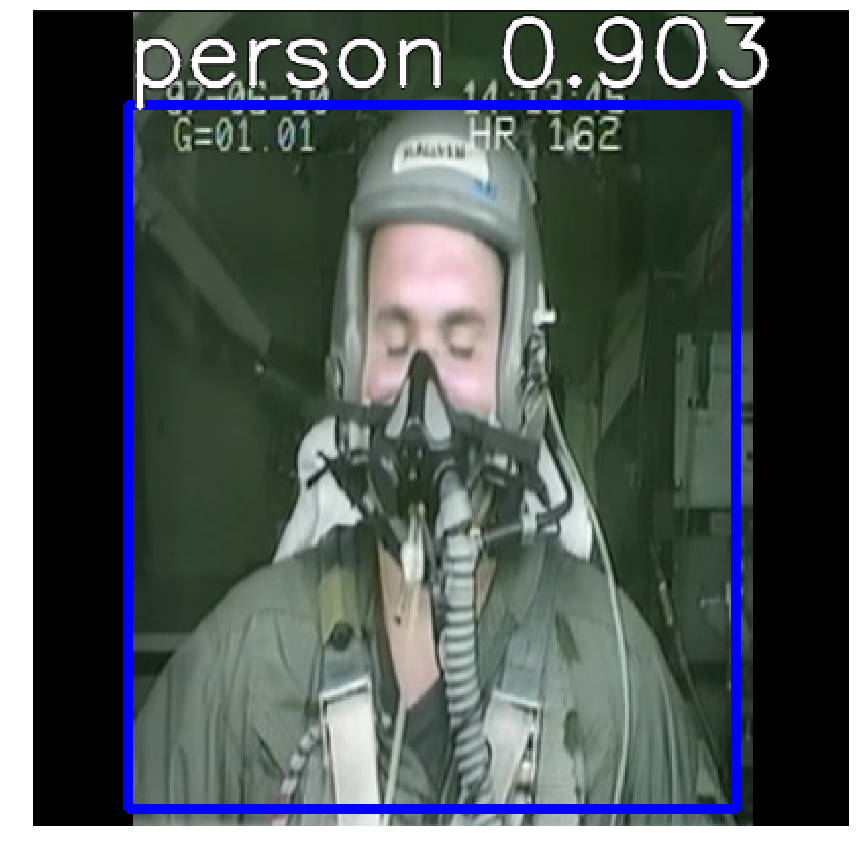

In [191]:
# folder = np.random.choice(folders)
detect_pilot(folder=np.random.choice(folders))

Image path: data/train/005106-005451/005352.jpg
processing time:  5.7991931438446045


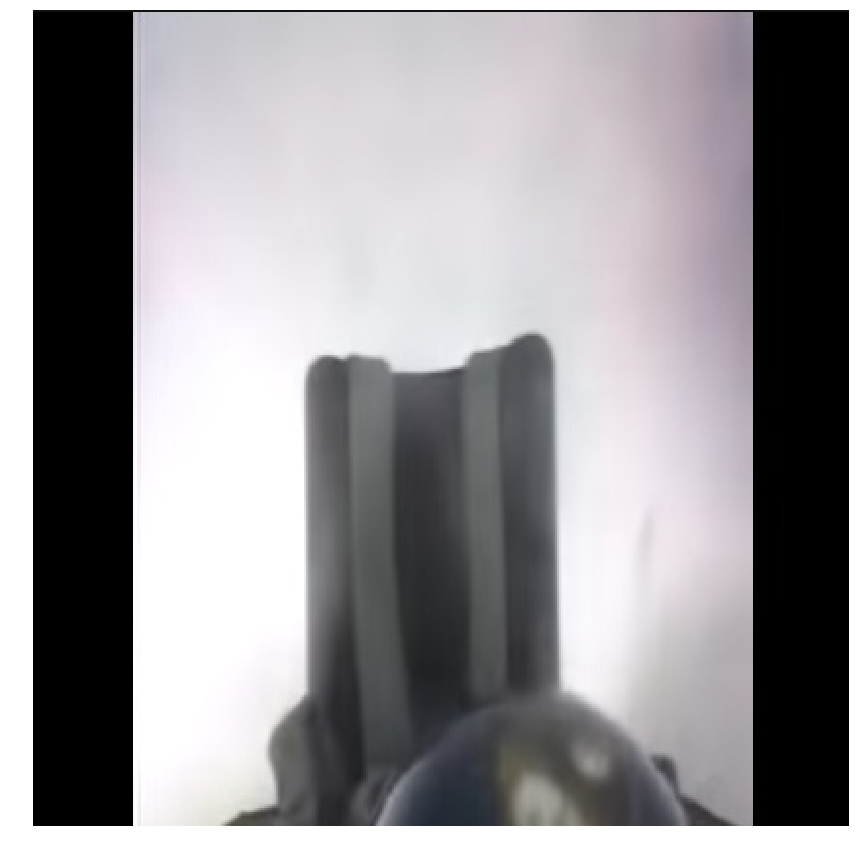

In [194]:
detect_pilot(folder=np.random.choice(folders))

Image path: data/train/006242-006439/006256.jpg
processing time:  6.117055416107178


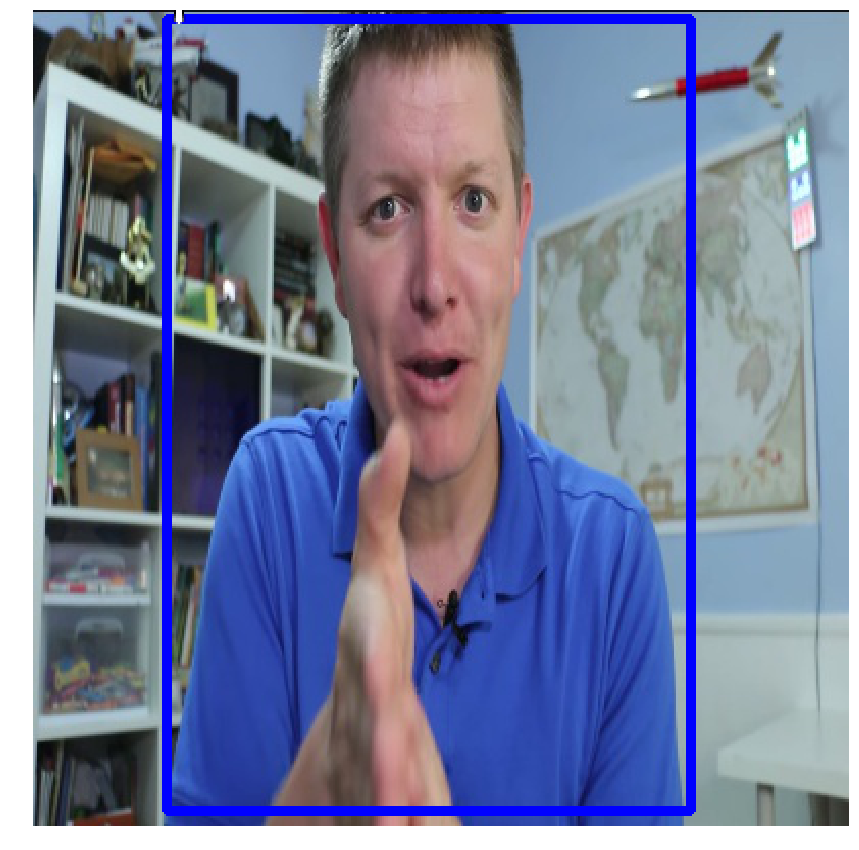

In [195]:
detect_pilot(folder=np.random.choice(folders))

Image path: data/train/006549-006672/006666.jpg
processing time:  5.892467975616455


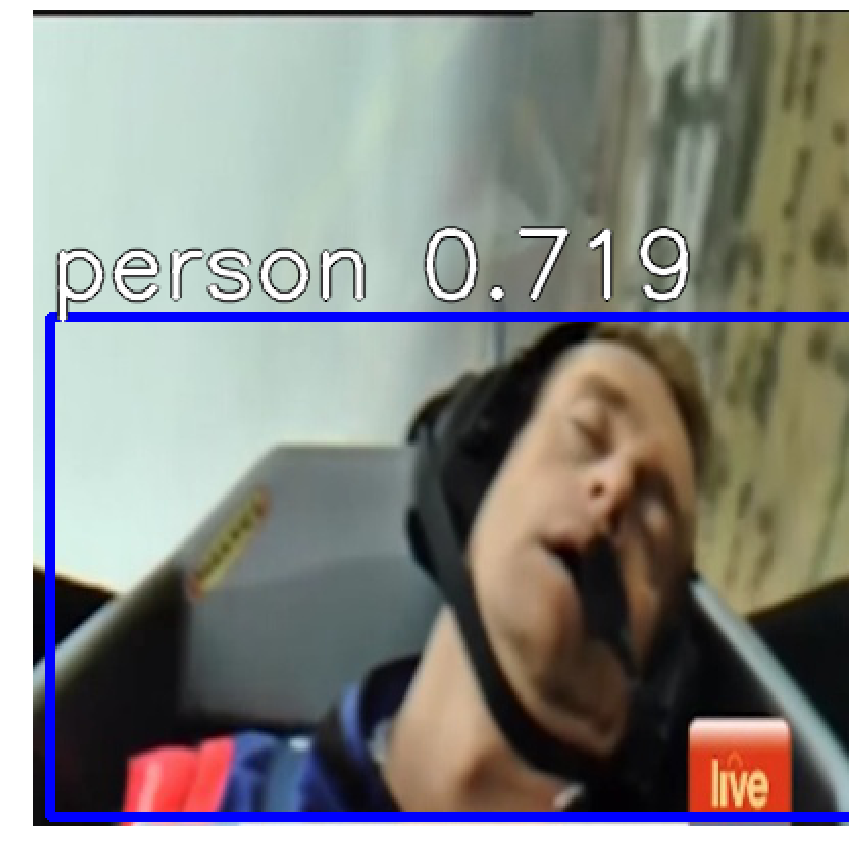

In [201]:
detect_pilot(folder=np.random.choice(folders), threshold=0.5)

Image path: data/train/003317-003603/003493.jpg
processing time:  5.794649839401245


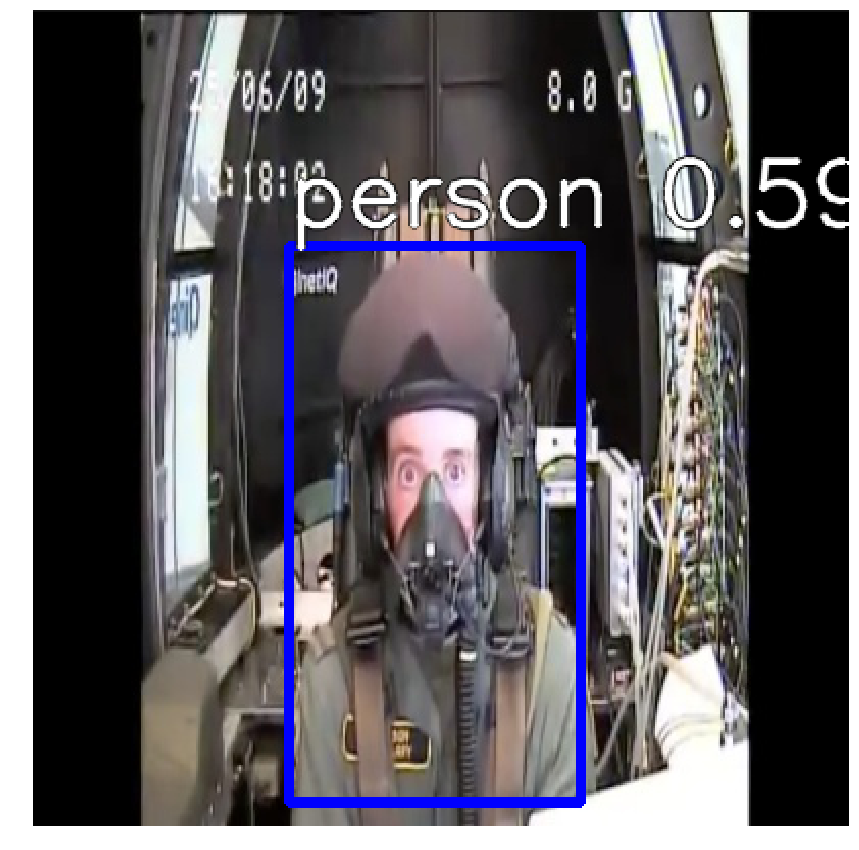

In [202]:
detect_pilot(folder=np.random.choice(folders), threshold=0.5)

Image path: data/train/001435-001882/001442.jpg
processing time:  7.3914313316345215


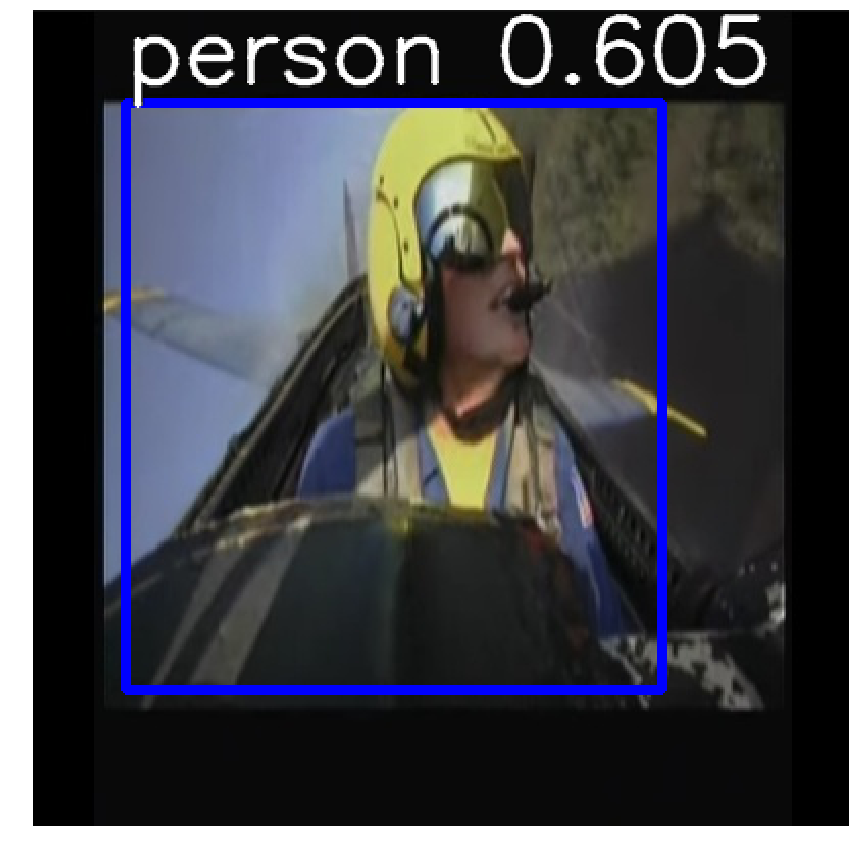

In [203]:
detect_pilot(folder=np.random.choice(folders), threshold=0.5)

Image path: data/train/006112-006241/006170.jpg
processing time:  6.328599214553833


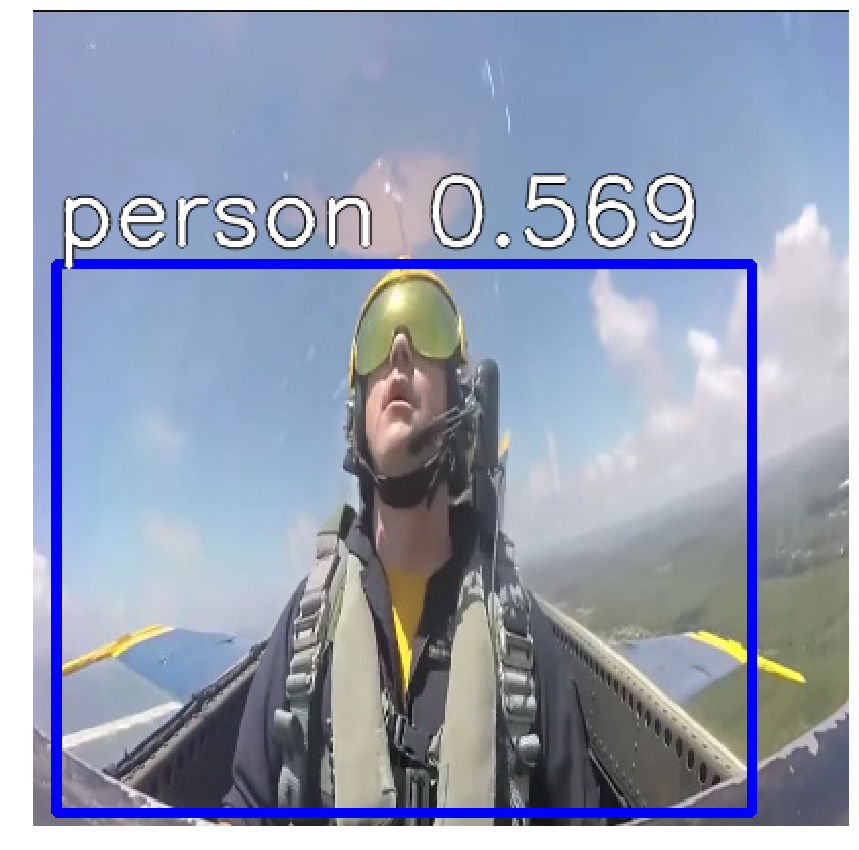

In [204]:
detect_pilot(folder=np.random.choice(folders), threshold=0.5)

Image path: data/train/000413-000569/000552.jpg
processing time:  5.92136812210083
person 0.575


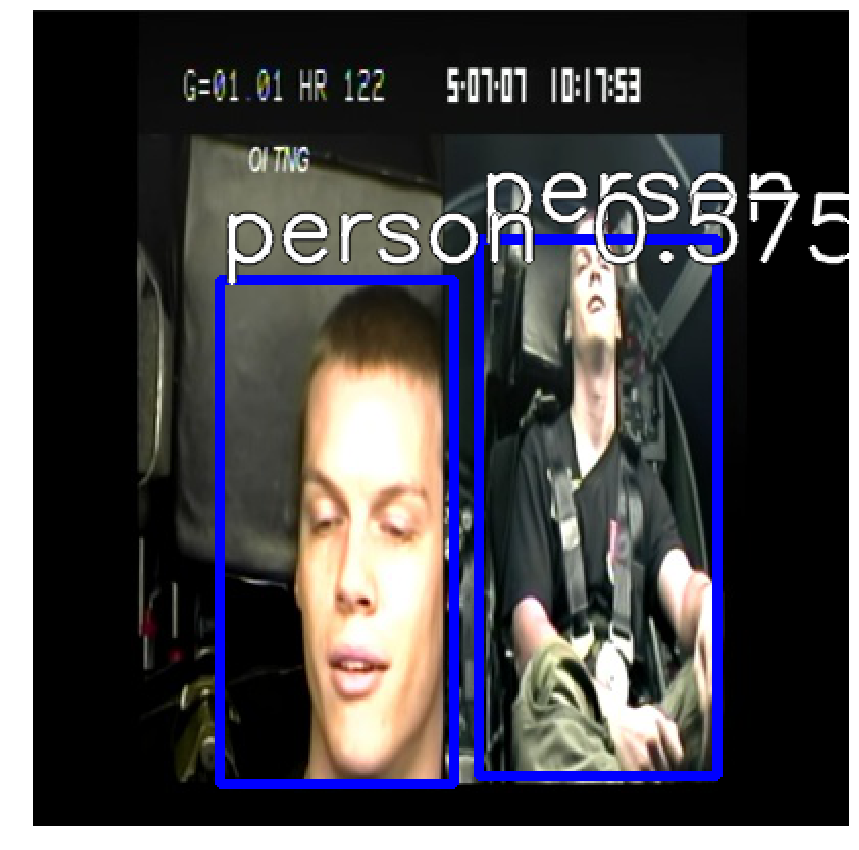

In [210]:
detect_pilot(folder=np.random.choice(folders), threshold=0.4)

Obviously some finetuning needed over the original RetinaNet model:

Image path: data/train/006242-006439/006330.jpg
processing time:  5.8650901317596436
motorcycle 0.545


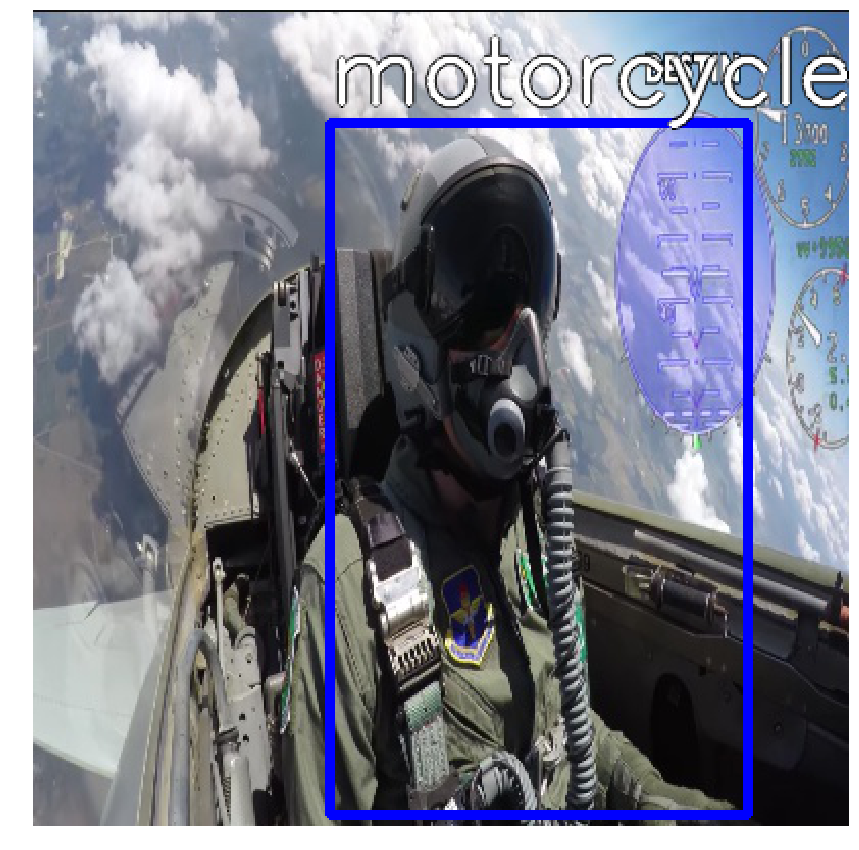

In [211]:
detect_pilot(folder=np.random.choice(folders), threshold=0.4)

Image path: data/train/003905-004151/004067.jpg
processing time:  5.670764923095703
person 0.497


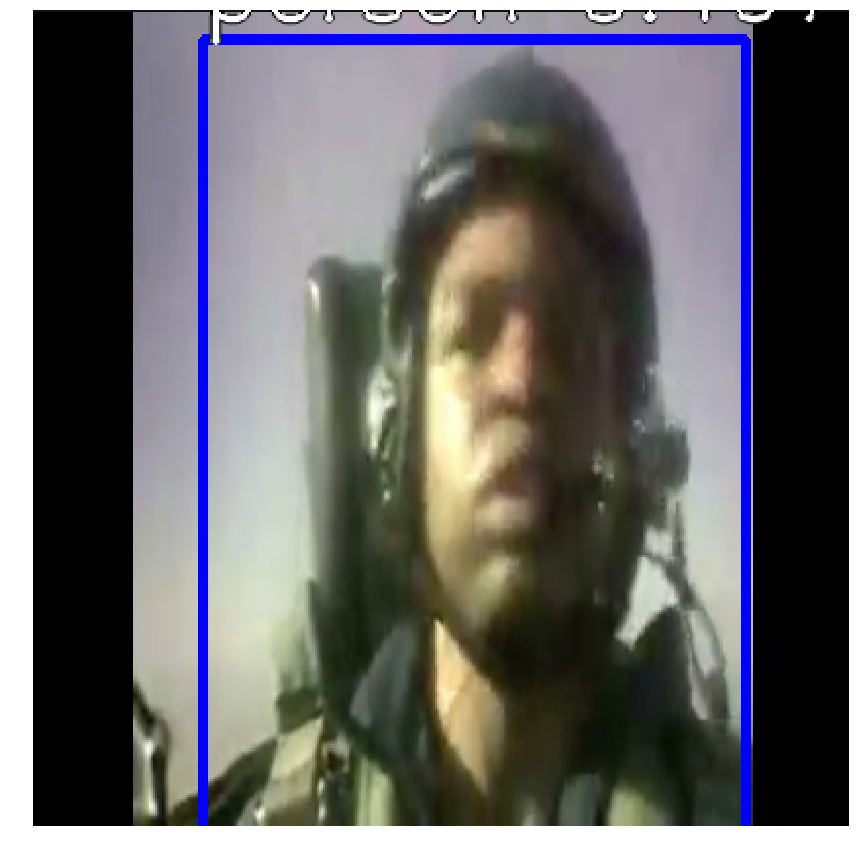

In [213]:
detect_pilot(folder=np.random.choice(folders), threshold=0.4)

Image path: data/train/006673-006860/006827.jpg
processing time:  6.250620126724243
person 0.608


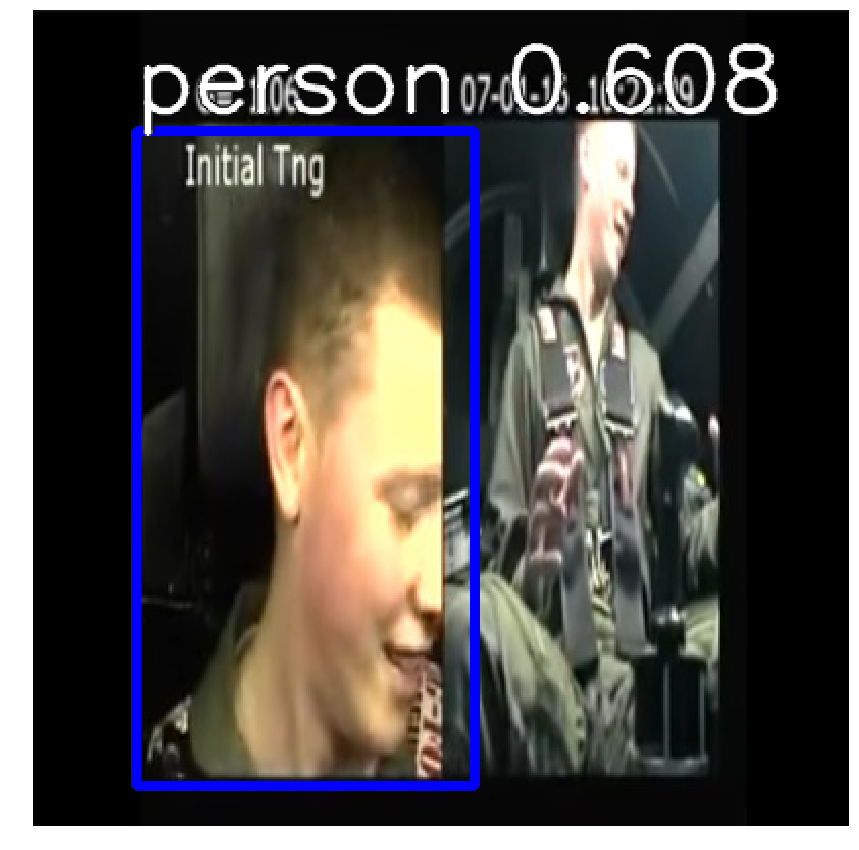

In [214]:
detect_pilot(folder=np.random.choice(folders), threshold=0.4)

Image path: data/train/002439-003316/002778.jpg
processing time:  5.728499412536621
person 0.609


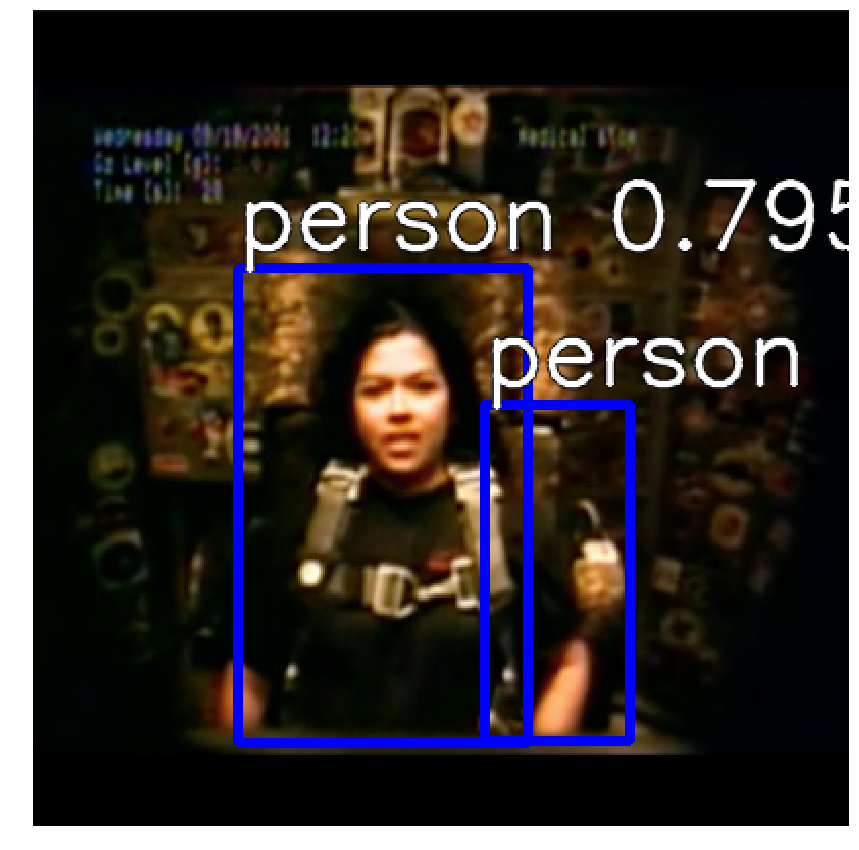

In [217]:
detect_pilot(folder=np.random.choice(folders), threshold=0.4)

Image path: data/train/001435-001882/001461.jpg
processing time:  6.029476881027222
snowboard 0.546


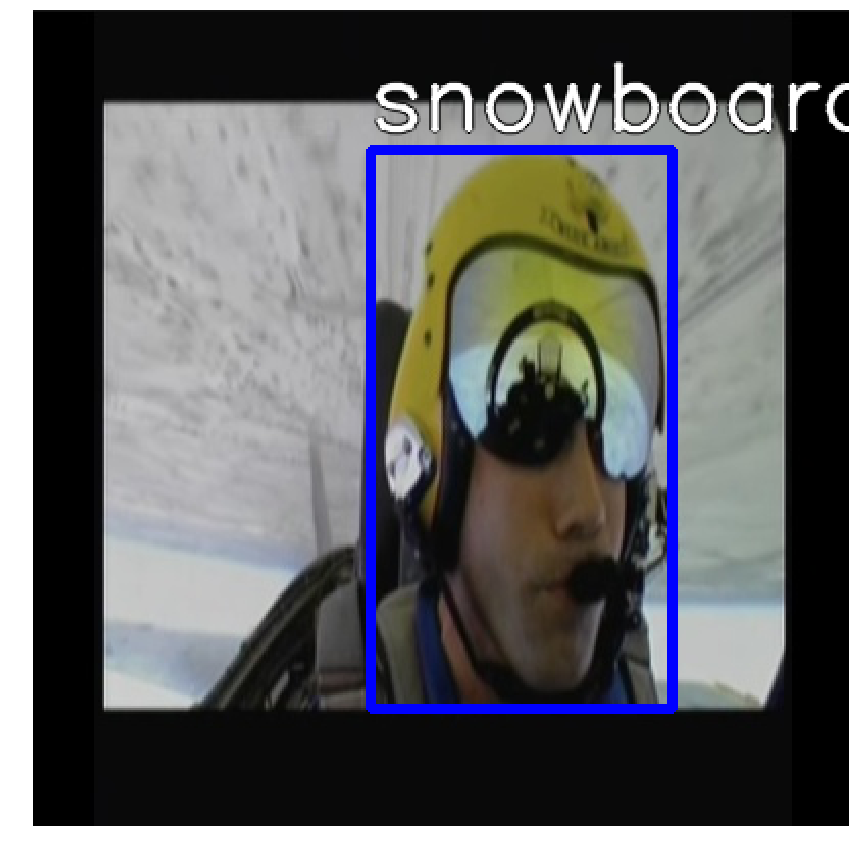

In [218]:
detect_pilot(folder=np.random.choice(folders), threshold=0.4)

Image path: data/train/001190-001434/001269.jpg
processing time:  6.315438747406006
cow 0.519


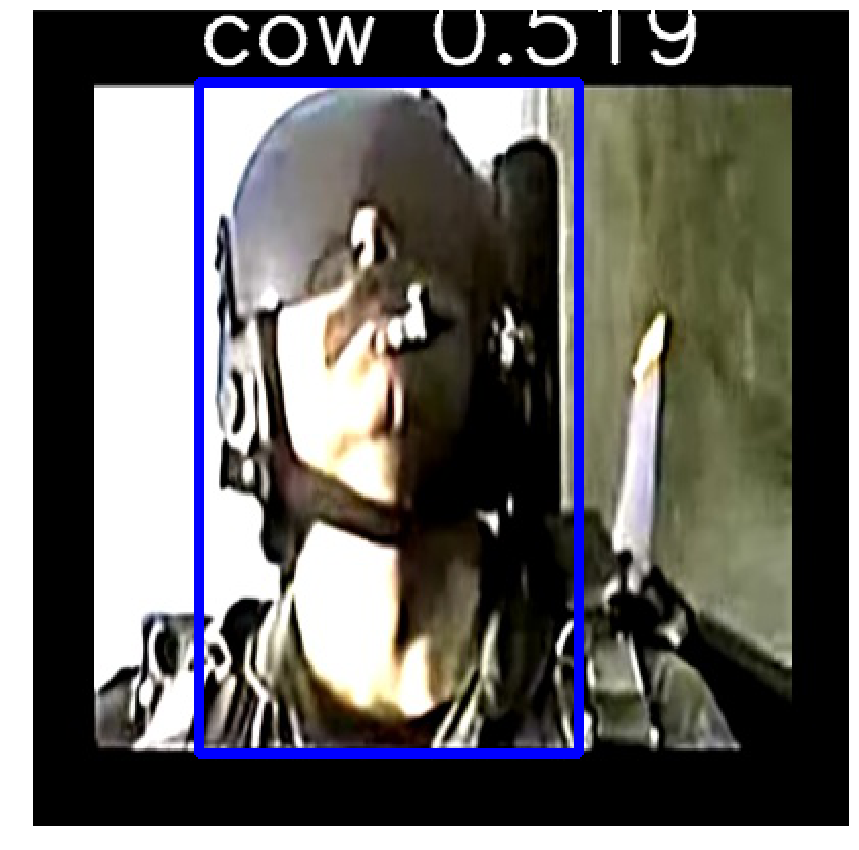

In [219]:
detect_pilot(folder=np.random.choice(folders), threshold=0.4)

Alrighty then. It doesn't matter that it's mis-identifying the pilots -- I doubt RetinaNet was pretrained to detect a "pilot" class anyway -- what matters is that it *can* detect *something*.

Those detections are also the highest-rated predictions, which is good. And it makes me think...

I originally thought to finetune RetinaNet as a simple "GLOC" classifier, and use its bounding boxes as a graphic to make the final demo of the detector look better. Then I learned two things.

1. All these classifier + bounding-box networks (YOLO, RetinaNet, etc) *don't* (far as I know -- 27 Dec 2017..) use the bounding boxes to feed into the classifier. They just run two seperate sub-networks: a classifier and a bounding-box maker, on top of a ConvNet backbone... meaning they don't talk to each other!

2. RetinaNet is actually *very good* at identifying the specific region of interest of the image. At least for what I want to do.

So... here's what I could do, at the expense of time (*but time well spent?*):

Finetune RetinaNet as a pilot/person detector. Use it to generate bounding boxes on the input data. Use those bounding boxes to send cropped images to the G-LOC detector. Classify. Repeat. For demonstration a final step: overlay that bounding box atop the original image along with its classification & confidence rating.

We can go further. I think it's mostly silly to rely soley on either static or neural (dynamic) algorithms (static: predefined, neural/dynamic: learned). Combine them. Use the neural net's weakness as a strength.

*What?*

--> RetinaNet has a hard time detecting anything if the pilot is totally slouched forward where only the top of the helmet and the seat are visible. So if nothing has been detected for long enough, raise the alarm: something's probably not right. There isn't a lot of room or reason to be bent forward in a jet's cockpit.

Those are some ideas, and I'm leaning towards implementing them the more I think about it.

---

NOTE: maybe I could save space on this notebook by printing out the images smaller. May do that later if it's too big.


-- Wayne H Nixalo

23:51 27 Dec 2017